# Regression Kriging: Comparing Covariates (Estero Bay)

This document includes Python codes that compare regression kriging with 1) bathymatry, 2) LDI, 3) basymatry+ LDI.

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Combine Discrete and Continuous Data](#preprocess)
* [3. Charlotte Harbor](#ch)
    * [3.1 Preview](#ch_preview)
    * [3.2 Dissolved Oxygen](#do)
        * [3.2.1 Regression Kriging (covariate: bathymetry](#do_bathy)
        * [3.2.2 Regression Kriging: (covariate: LDI)](#do_ldi)
        * [3.2.3 Regression Kriging (covariate: bathymetry+LDI](#do_b_ldi)
        * [3.2.4 Interpolation Validation](#do_val)
    * [3.3 Salinity](#s)
        * [3.3.1 Regression Kriging (covariate: bathymetry](#s_bathy)
        * [3.3.2 Regression Kriging: (covariate: LDI)](#s_ldi)
        * [3.3.3 Regression Kriging (covariate: bathymetry+LDI](#s_b_ldi)
        * [3.3.4 Interpolation Validation](#s_val)
    * [3.4 Total Nitrogen](#tn)
        * [3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry](#tn_bathy)
        * [3.4.2 Regression Kriging of Total Nitrogen: (covariate: LDI)](#tn_ldi)
        * [3.4.3 Regression Kriging of Total Nitrogen (covariate: bathymetry+LDI](#tn_b_ldi)
        * [3.4.4 Interpolation Validation of Total Nitrogen](#tn_val)
    * [3.5 Turbidity](#t)
        * [3.5.1 Regression Kriging of Turbidity (covariate: bathymetry](#t_bathy)
        * [3.5.2 Regression Kriging of Turbidity (covariate: LDI)](#t_ldi)
        * [3.5.3 Regression Kriging of Turbidity (covariate: bathymetry+LDI](#t_b_ldi)
        * [3.5.4 Interpolation Validation of Turbidity](#t_val)
    * [3.6 Secchi Depth](#sd)
        * [3.6.1 Regression Kriging of Secchi Depth (covariate: bathymetry](#sd_bathy)
        * [3.6.2 Regression Kriging of Secchi Depth: (covariate: LDI)](#sd_ldi)
        * [3.6.3 Regression Kriging of Secchi Depth (covariate: bathymetry+LDI](#sd_b_ldi)
        * [3.6.4 Interpolation Validation of Secchi Depth](#sd_val)

In [2]:
import time, math, os, importlib
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx

import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [3]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [4]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [5]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [7]:
# Set variables of the program
year = "2017"
Area = 'Estero Bay Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'
b_name = 'eb'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\1036427667.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\1036427667.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [8]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Estero Bay <a class="anchor" id="ch"></a>
## 3.1 Preview Data <a class="anchor" id="ch_preview"></a>

In [9]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

ma_table = pd.read_csv(gis_path + "MA_table.csv")

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [10]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

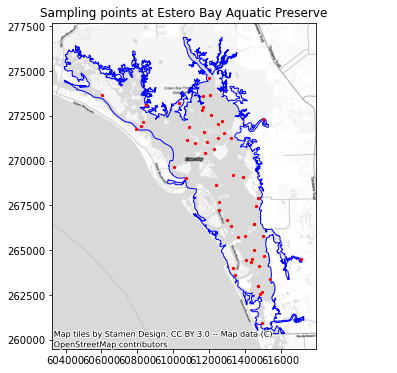

In [11]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 3.2 Dissolved Oxygen <a class="anchor" id="do"></a>

### 3.2.1 Regression Kriging (covariate: bathymetry) <a class="anchor" id="do_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

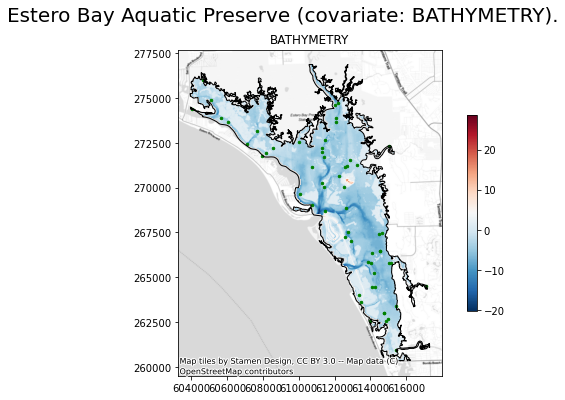

In [12]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate.upper(), ax, fig)

RK interpolation

In [13]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 45.52473211288452 seconds ---
Start the interpolation with the RK method
--- Time lapse: 40.17585372924805 seconds ---


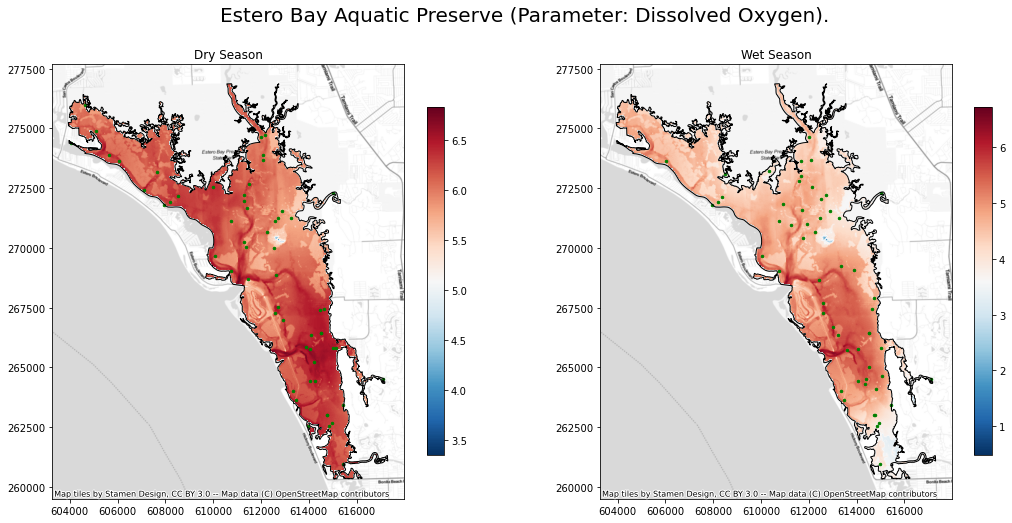

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.2.2 Regression Kriging (covariate: LDI) <a class="anchor" id="do_ldi"></a>


RK interpolation

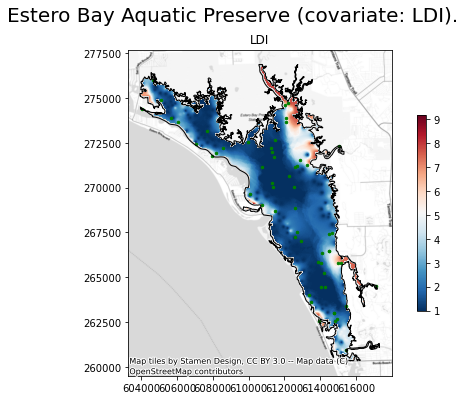

In [15]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [16]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 44.342151165008545 seconds ---
Start the interpolation with the RK method
--- Time lapse: 42.660571575164795 seconds ---


Plot the interpolation result

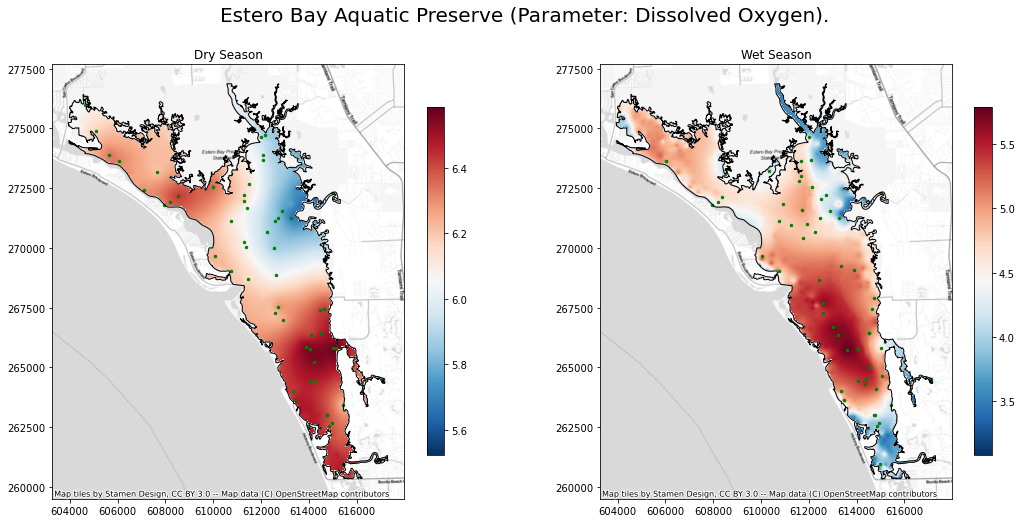

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.2.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="do_ldi_bathy"></a>


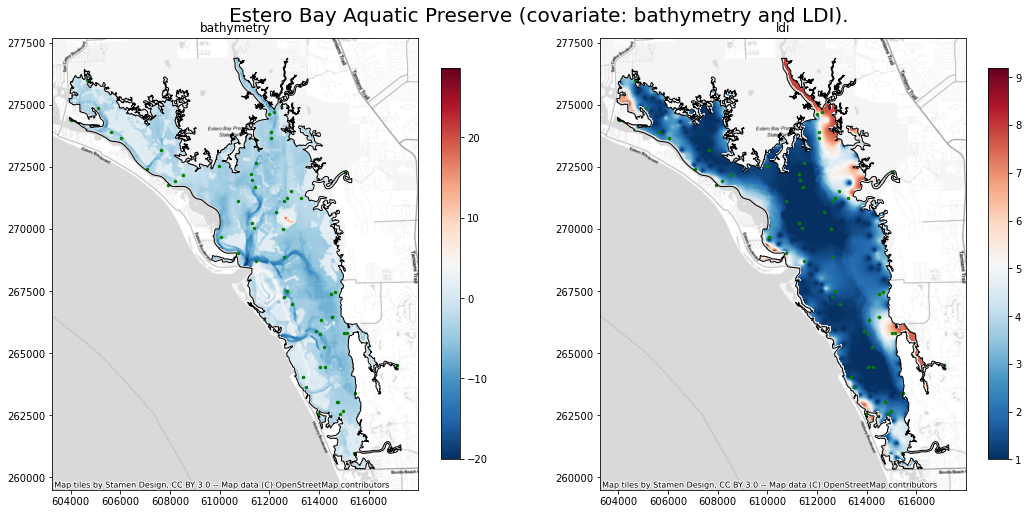

In [18]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [19]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 61.8758225440979 seconds ---
Start the interpolation with the RK method
--- Time lapse: 63.7749924659729 seconds ---


Plot interpolation results

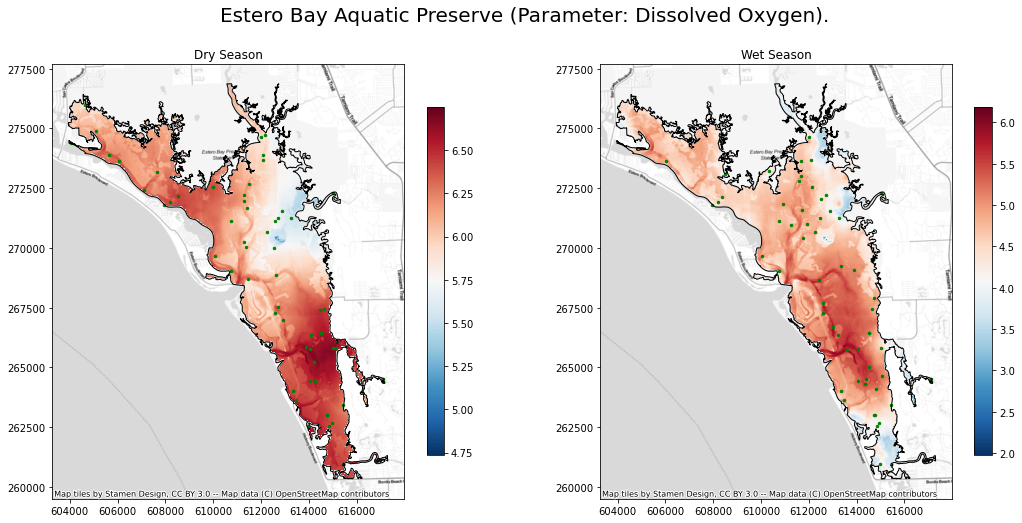

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.2.4 Validation Summary <a class="anchor" id="do_val_sum"></a>

In [21]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0152                -0.0205               1.0663
RK    -0.0007                -0.0024               0.9331
RK     0.0047                 0.0064               0.9314

In [22]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0121                 0.0015               0.9462
RK    -0.0018                -0.0094               0.9009
RK     0.0014                -0.0036               0.8934

## 3.3 Interpolation of Salinity <a class="anchor" id="s"></a>

Select salinity data

In [28]:
# Set variables of the program
year = "2007"
Para = 'Salinity'
Para_ab = "S"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

# ---------------------------- Uncomment in the first run --------------------------

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\3580639223.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\3580639223.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [29]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

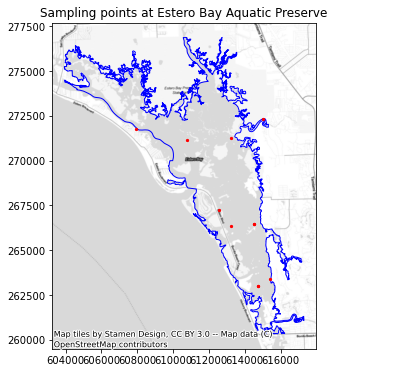

In [30]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.3.1 Regression Kriging of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

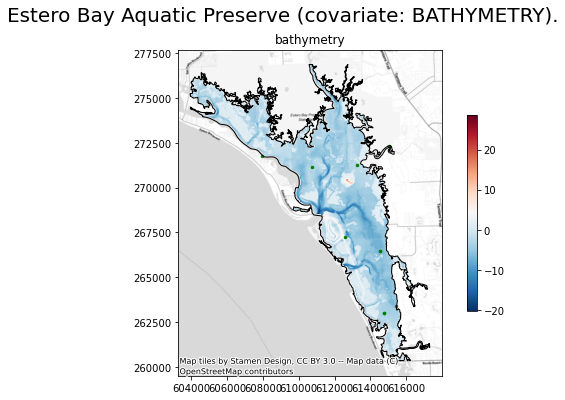

In [31]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [32]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method


ExecuteError: ERROR 040039: Not enough data to compute method.
Failed to execute (EBKRegressionPrediction).


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.3.2 Regression Kriging (covariate: LDI) <a class="anchor" id="s_ldi"></a>


RK interpolation

In [ ]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [ ]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Plot the interpolation result

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.3.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="si_ldi_bathy"></a>


In [ ]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [ ]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Plot interpolation results

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.3.4 Validation Summary <a class="anchor" id="s_val_sum"></a>

In [ ]:
sumStatDry2   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry2

In [ ]:
sumStatWet2   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet2

## 3.4 Interpolation of Total Nitrogen <a class="anchor" id="tn"></a>

Select data

In [35]:
# Set variables of the program
year, Para, Para_ab  ='2014', 'Total Nitrogen', "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\389651132.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\389651132.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [36]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [37]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

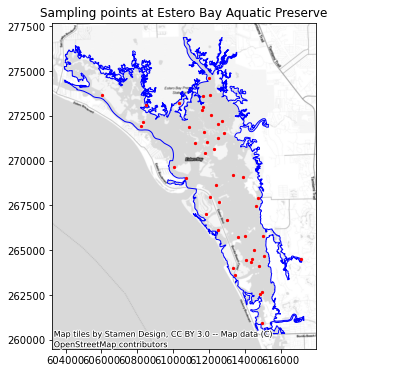

In [38]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry) <a class="anchor" id="tn_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

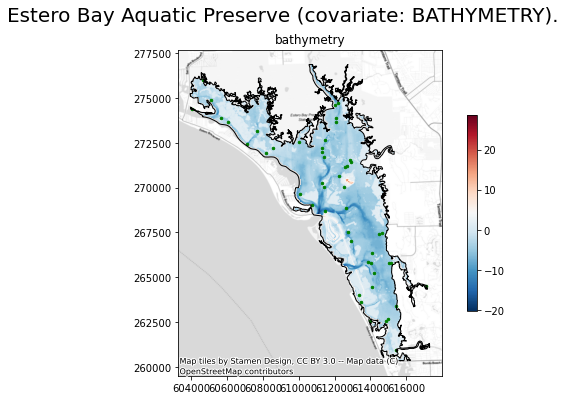

In [39]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [40]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 13.293361902236938 seconds ---
Start the interpolation with the RK method
--- Time lapse: 13.848224878311157 seconds ---


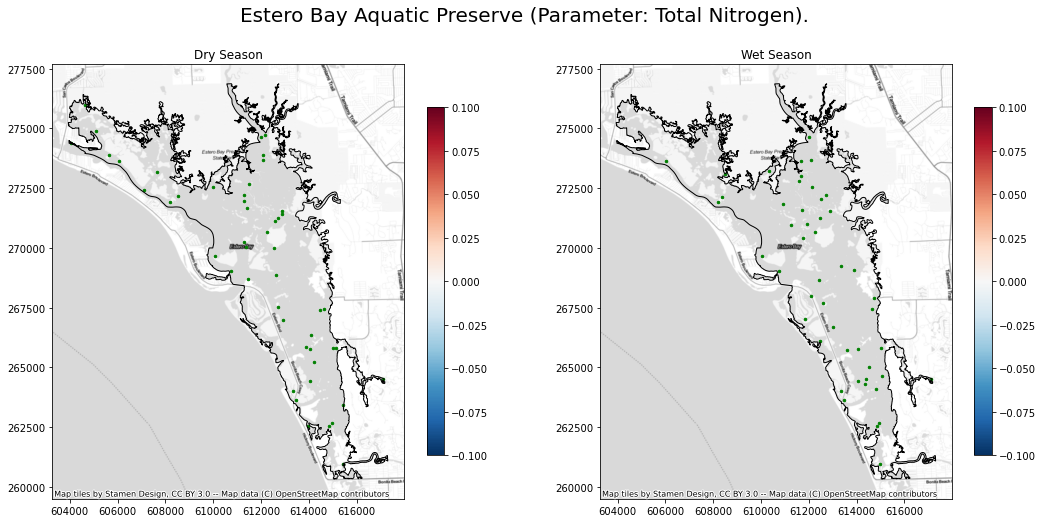

In [41]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.4.2 Regression Kriging (covariate: LDI) <a class="anchor" id="tn_ldi"></a>


RK interpolation

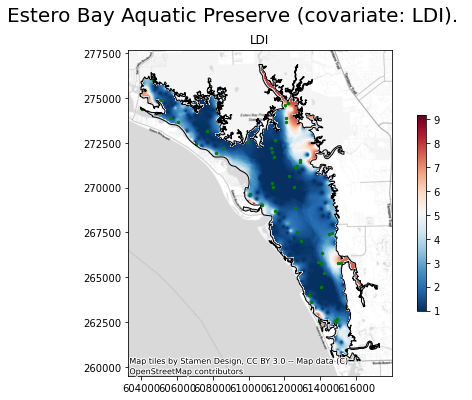

In [42]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [43]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 12.733083963394165 seconds ---
Start the interpolation with the RK method
--- Time lapse: 13.994673252105713 seconds ---


Plot the interpolation result

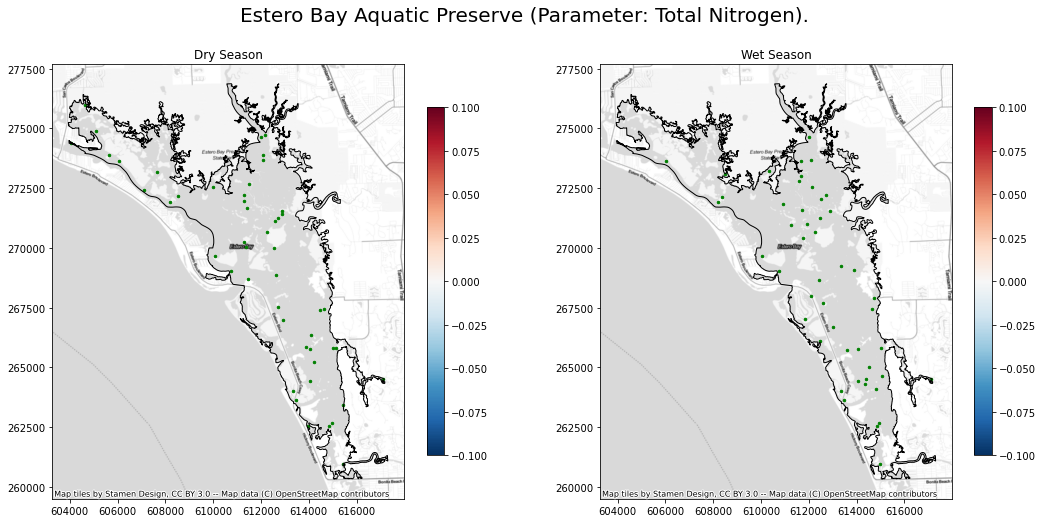

In [44]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.4.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="tn_ldi_bathy"></a>


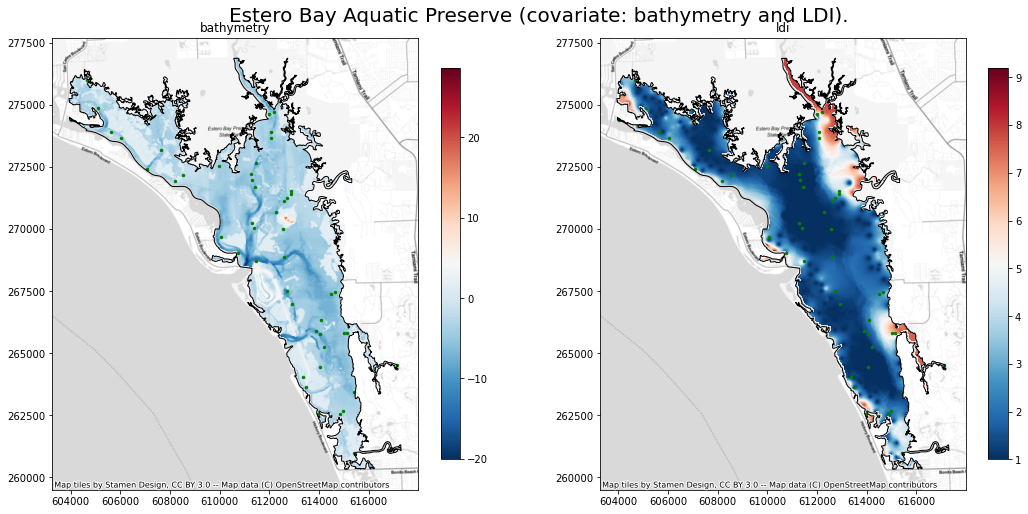

In [45]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [46]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 12.085307836532593 seconds ---
Start the interpolation with the RK method
--- Time lapse: 13.794034957885742 seconds ---


Plot interpolation results

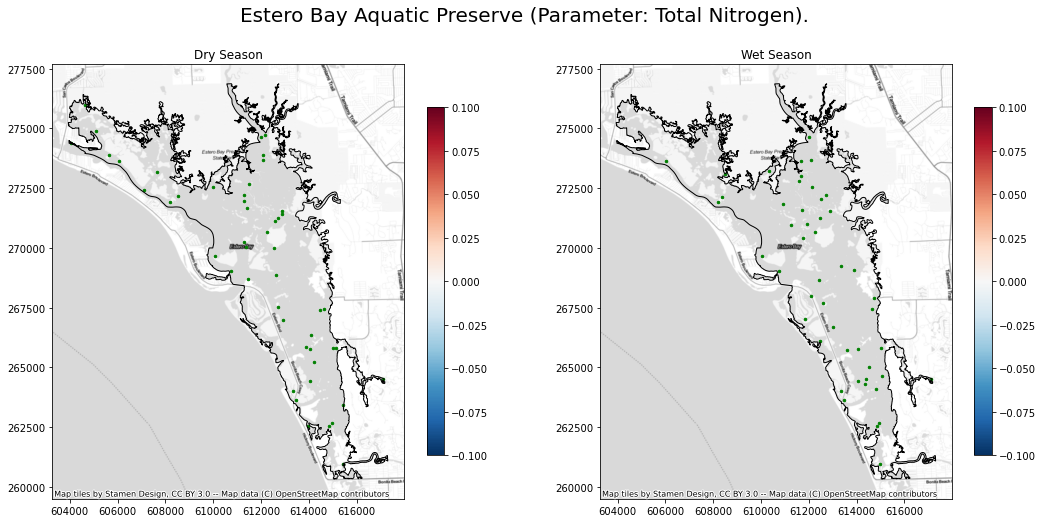

In [47]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.4.4 Validation Summary <a class="anchor" id="tn_val_sum"></a>

In [48]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0097                 0.0452               0.1981
RK     0.0134                 0.0612               0.1949
RK     0.0116                 0.0536               0.1921

In [49]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0122                -0.0532               0.2268
RK    -0.0106                -0.0345               0.2296
RK    -0.0006                -0.0121               0.2118

## 3.5 Interpolation of Turbidity <a class="anchor" id="t"></a>

Select data

In [50]:
year,Para,Para_ab = "2014", 'Turbidity', "T"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\2848871626.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\2848871626.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [51]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [52]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

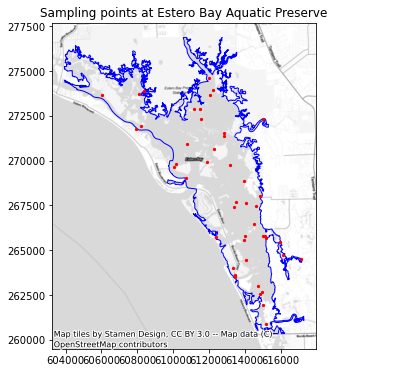

In [53]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.5.1 Regression Kriging of Turbidity (covariate: bathymetry) <a class="anchor" id="t_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

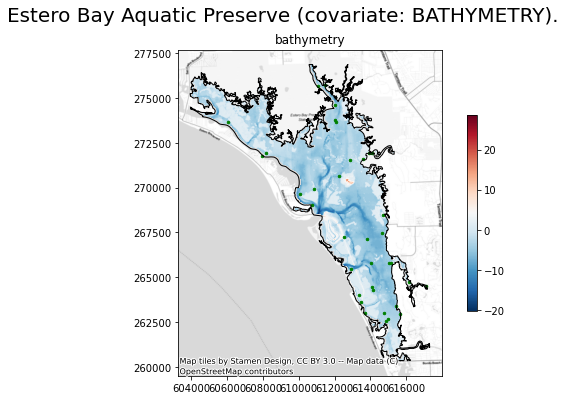

In [54]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [55]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 12.632713317871094 seconds ---
Start the interpolation with the RK method
--- Time lapse: 13.578978538513184 seconds ---


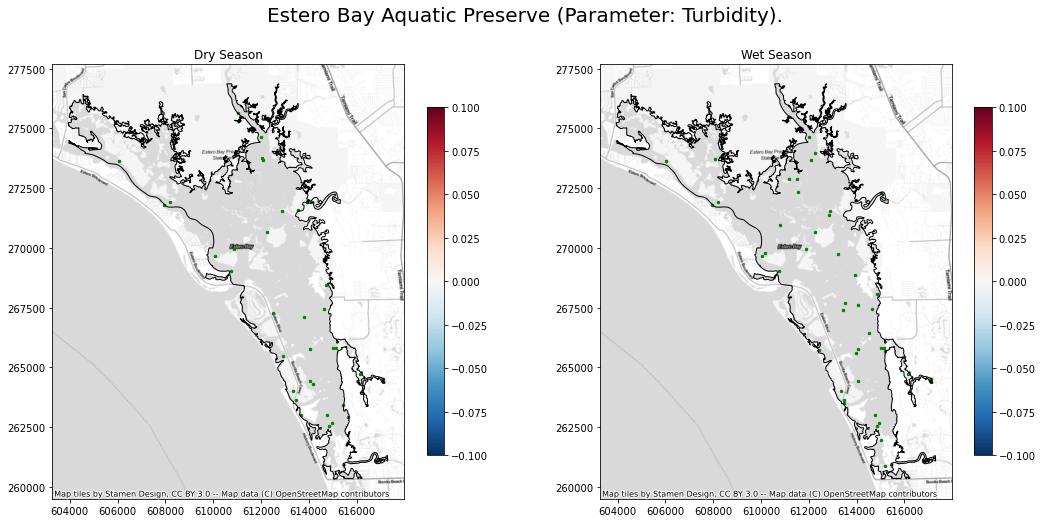

In [56]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.5.2 Regression Kriging (covariate: LDI) <a class="anchor" id="t_ldi"></a>


RK interpolation

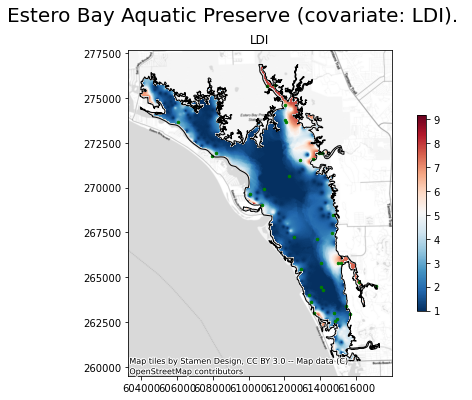

In [57]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [58]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 12.37734341621399 seconds ---
Start the interpolation with the RK method
--- Time lapse: 13.702147960662842 seconds ---


Plot the interpolation result

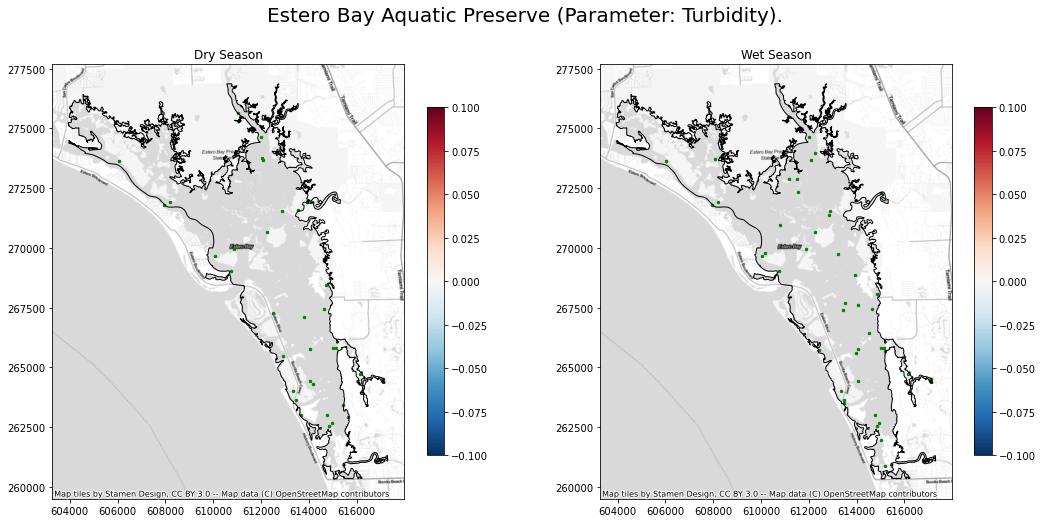

In [59]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.5.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="t_ldi_bathy"></a>


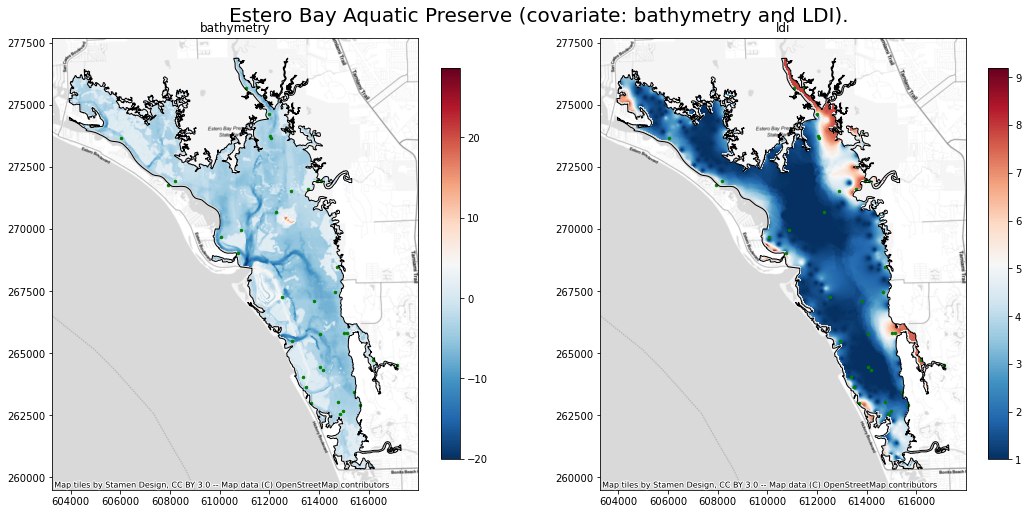

In [60]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [61]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 12.398804187774658 seconds ---
Start the interpolation with the RK method
--- Time lapse: 12.40139889717102 seconds ---


Plot interpolation results

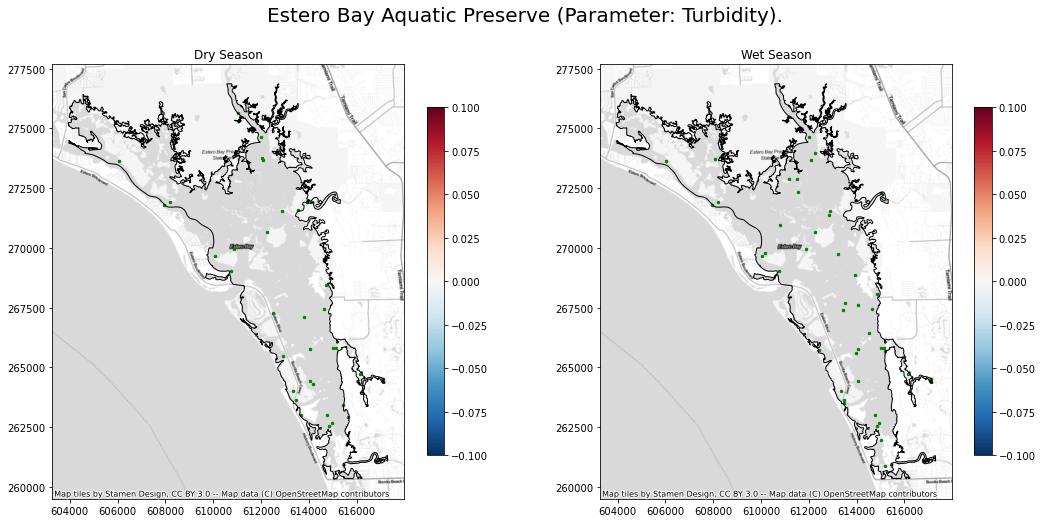

In [62]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.5.4 Validation Summary <a class="anchor" id="t_val_sum"></a>

In [63]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0485                 0.0144               2.1732
RK     0.1058                 0.0448               2.1649
RK     0.0621                 0.0204               2.1597

In [64]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0269                -0.0028               1.6699
RK    -0.0116                -0.0215               1.6746
RK     0.0156                -0.0023               1.6809

## 3.6 Interpolation of Secchi Depth <a class="anchor" id="sd"></a>

Select data

In [65]:
year,Para,Para_ab = "2006", 'Secchi Depth', "SD"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\1825365313.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_39152\1825365313.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [66]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [67]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

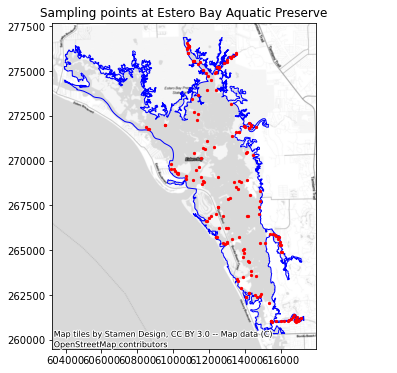

In [68]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.6.1 Regression Kriging of Turbidity (covariate: bathymetry) <a class="anchor" id="sd_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

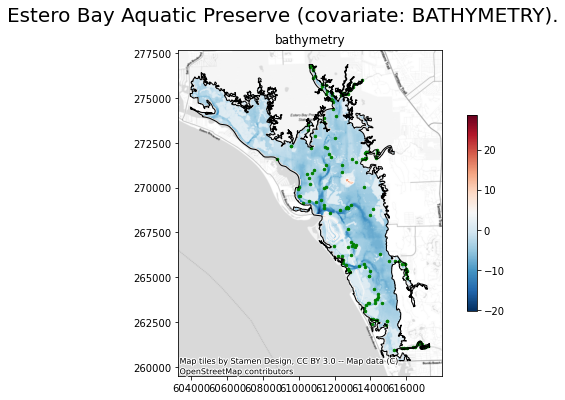

In [69]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [70]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 15.046627521514893 seconds ---
Start the interpolation with the RK method
--- Time lapse: 14.890681266784668 seconds ---


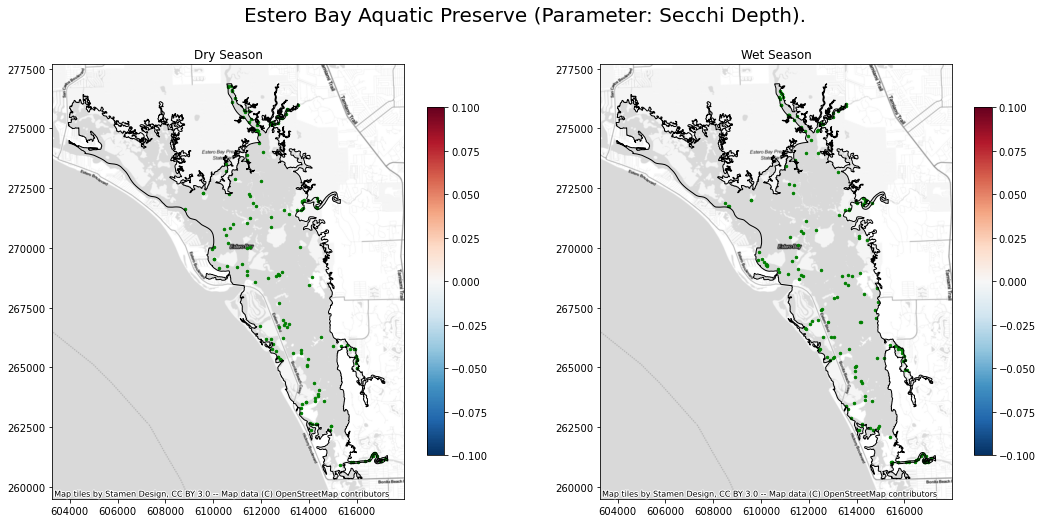

In [71]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.6.2 Regression Kriging (covariate: LDI) <a class="anchor" id="sd_ldi"></a>


RK interpolation

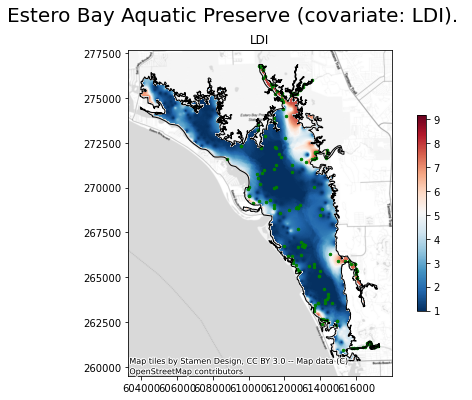

In [72]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [73]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 13.164675235748291 seconds ---
Start the interpolation with the RK method
--- Time lapse: 14.417476177215576 seconds ---


Plot the interpolation result

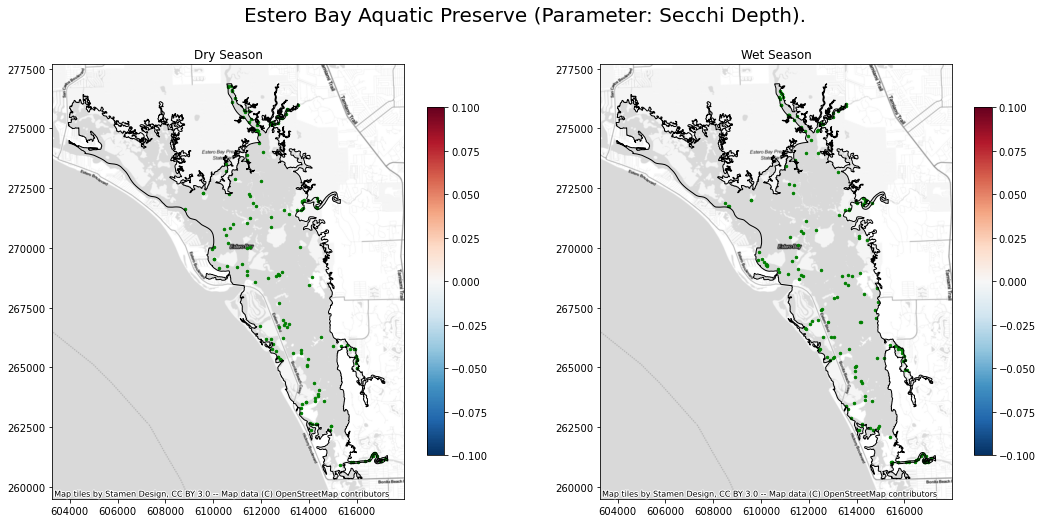

In [74]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.6.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="sd_ldi_bathy"></a>


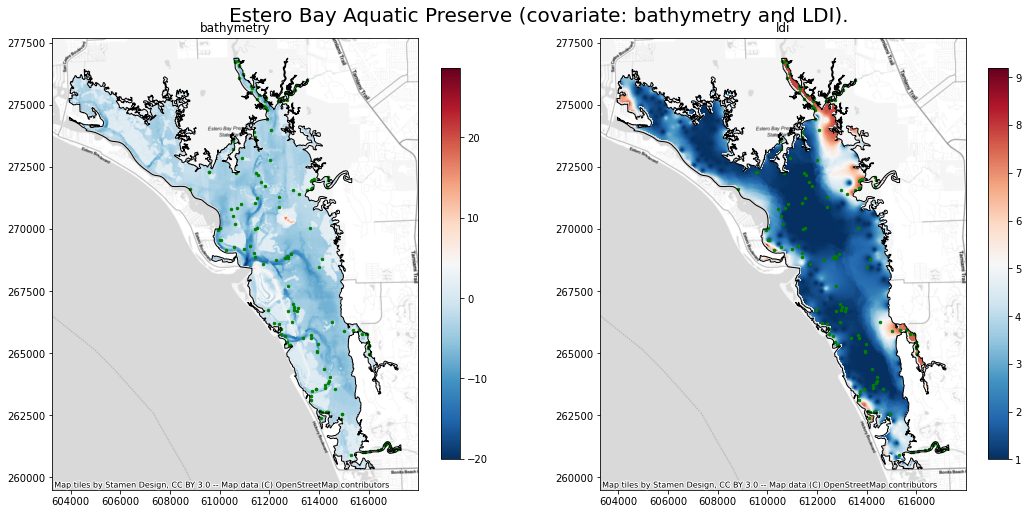

In [75]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [76]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 13.752724647521973 seconds ---
Start the interpolation with the RK method
--- Time lapse: 14.897777080535889 seconds ---


Plot interpolation results

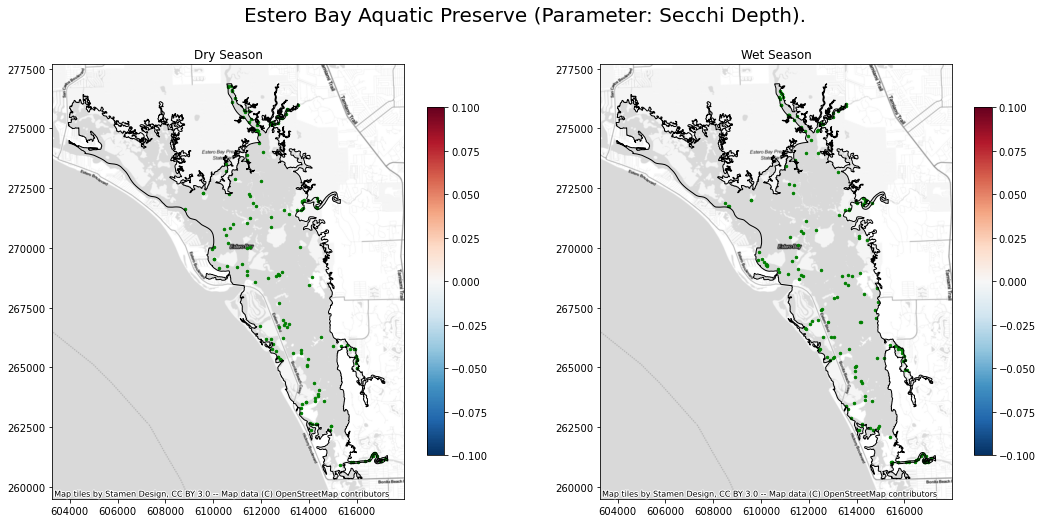

In [77]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)

### 3.6.4 Validation Summary <a class="anchor" id="sd_val_sum"></a>

In [78]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0000                -0.0068               0.2672
RK     0.0075                 0.0225               0.3003
RK    -0.0034                -0.0194               0.2664

In [79]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0024                 0.0195               0.3645
RK     0.0044                 0.0168               0.3805
RK    -0.0052                 0.0020               0.3562